In [1]:
import fnmatch
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

from astropy.io import fits

In [2]:
cols = ['unflagged', 'n_times_unflagged', 'flags', 'fully_flagged', 'any_tv', 'any_streak', 'any_recur_nb', 'any_rando_nb', 'any_pdrop', 'pdrop_ntimes', 'TV6', 'time_broadcast_TV6', 'TV7', 'time_broadcast_TV7', 'TV8', 'time_broadcast_TV8',
       'TV9', 'time_broadcast_TV9','TV_ntimes', 'streak', 'time_broadcast_streak', 'streak_ntimes','narrow_168.760MHz','narrow_172.800MHz','narrow_175.000MHz','time_broadcast_narrow_175.000MHz','narrow_180.000MHz','time_broadcast_narrow_180.000MHz','narrow_191.440MHz','narrow_191.480MHz', 'narrow_ntimes', 'random_narrow_chan', 'random_narrow_ntimes']

In [3]:
df_dict = {}
for i in cols:
    df_dict[i] = [0] * 319
df_dict['random_narrow_chan'] = [[0]] * 319

In [4]:
obsids = []
yaml_dir = '/Users/pstar/EoRanalysis/mwax_plots/ssins_plots/test_order2_streak5/SSINS_output/'
input_files = glob.glob(yaml_dir + '*match_events.yml')
for infile in input_files:
    obsids.append(int(infile.split('/')[-1].split('_')[0]))
print(len(obsids))

319


In [5]:
def initialize_df(obsids, metadir='/Users/pstar/EORanalysis/mwax_data/metafits/2021/'):
    cols = ['unflagged', 'n_times_unflagged', 'flags', 'fully_flagged', 'any_tv', 'any_streak', 'any_recur_nb', 'any_rando_nb', 'any_pdrop', 'pdrop_ntimes', 'TV6', 'time_broadcast_TV6', 'TV7', 'time_broadcast_TV7', 'TV8', 'time_broadcast_TV8',
           'TV9', 'time_broadcast_TV9','TV_ntimes', 'streak', 'time_broadcast_streak', 'streak_ntimes','narrow_168.760MHz','narrow_172.800MHz','narrow_175.000MHz','time_broadcast_narrow_175.000MHz','narrow_180.000MHz','time_broadcast_narrow_180.000MHz','narrow_191.440MHz','narrow_191.480MHz', 'narrow_ntimes', 'random_narrow_chan', 'random_narrow_ntimes']
    df_dict = {}
    for i in cols:
        df_dict[i] = [0] * len(obsids)
    df_dict['random_narrow_chan'] = [[0]] * len(obsids)
    df = pd.DataFrame(df_dict, index=obsids)
    for i in obsids:
        with fits.open(metadir + str(i) + '.metafits') as meta:
            df.loc[i, 'lst'] = meta[0].header['LST']
    
    return df

In [6]:
df_nb = initialize_df(obsids)

In [7]:
df = initialize_df(obsids)

In [8]:
df2 = pd.read_csv('/Users/pstar/EORanalysis/mwax_ssins/ssins_orig_flagging.csv', index_col='obsids')

In [9]:
df_std = initialize_df(obsids)

In [10]:
df_o2 = initialize_df(obsids)

In [11]:
for i in obsids:
    df_o2.loc[i, 'day'] = int(df2.loc[int(i), 'day'])
    df_o2.loc[i, 'pointing'] = int(df2.loc[int(i), 'pointing'])

In [12]:
for i in obsids:
    df_std.loc[i, 'day'] = int(df2.loc[int(i), 'day'])
    df_std.loc[i, 'pointing'] = int(df2.loc[int(i), 'pointing'])

In [13]:
for i in obsids:
    df_nb.loc[i, 'day'] = int(df2.loc[int(i), 'day'])
    df_nb.loc[i, 'pointing'] = int(df2.loc[int(i), 'pointing'])

In [14]:
for i in obsids:
    df.loc[i, 'day'] = int(df2.loc[int(i), 'day'])
    df.loc[i, 'pointing'] = int(df2.loc[int(i), 'pointing'])

In [15]:
def ssins_yaml_to_df(yaml_dir, df, ntimes=59):
    input_files = glob.glob(yaml_dir + '*match_events.yml')
    for infile in input_files:
        obsid = int(infile.split('/')[-1].split('_')[0])
        flag_zero = False
        with open(infile, 'r') as stream:
            time_unflagged = np.full(ntimes+1, True)
            data = yaml.safe_load(stream)
            # if unflagged, stop here
            if data['freq_bounds'] == []:
                df.loc[obsid, 'unflagged'] = 1
            else:
                df.loc[obsid, 'flags'] = 1
                # simple_df.loc([obsid, 'flags']) = 1
                # iterate over rfi
                num_rfi = len(data['shape'])
                for j in range(num_rfi):
                    if data['shape'][j] == 'freq_broadcast_streak':
                        continue
                    else:
                        time_extant = data['time_bounds'][j][1] - data['time_bounds'][j][0]
                        if time_extant == ntimes:
                            df.loc[obsid, 'fully_flagged'] = 1
                            time_unflagged[:] = False
                        else:
                            time_unflagged[data['time_bounds'][j][0] : data['time_bounds'][j][1] + 1] = False
                        # check if in keys
                        if data['shape'][j] in df.columns:
                            df.loc[obsid, data['shape'][j]] = 1
                            if len(fnmatch.filter([data['shape'][j]], '*narrow*')) != 0:
                                df.loc[obsid, 'narrow_ntimes'] += time_extant
                                df.loc[obsid, 'any_recur_nb'] = 1
                            elif len(fnmatch.filter([data['shape'][j]], '*TV*')) != 0:
                                df.loc[obsid, 'TV_ntimes'] += time_extant
                                df.loc[obsid, 'any_tv'] = 1
                            elif len(fnmatch.filter([data['shape'][j]], '*streak*')) != 0:
                                df.loc[obsid, 'streak_ntimes'] +=time_extant
                                df.loc[obsid, 'any_streak'] = 1
                            else:
                                print(data['shape'][j])
                        elif len(fnmatch.filter([data['shape'][j]], '*packet*')) != 0:
                                df.loc[obsid, 'pdrop_ntimes'] +=time_extant
                                df.loc[obsid, 'any_pdrop'] = 1
                        elif len(fnmatch.filter([data['shape'][j]], '*narrow*')) != 0:
                            df.loc[obsid, 'random_narrow_ntimes'] += time_extant
                            df.loc[obsid, 'any_rando_nb'] = 1
                            if df.loc[obsid, 'random_narrow_chan'] == [0]:
                                df.loc[obsid, 'random_narrow_chan'] = [float(data['shape'][j][-10:-4])]
                            else:
                                df.loc[obsid, 'random_narrow_chan'].append(float(data['shape'][j][-10:-4]))
                        else:
                            print(data['shape'][j])
            df.loc[obsid, 'n_times_unflagged'] = len(np.nonzero(time_unflagged)[0])
            if flag_zero and df.loc[obsid, 'n_times_unflagged'] == 59:
                print(obsid)


In [16]:
ssins_yaml_to_df("/Users/pstar/EORanalysis/mwax_ssins/ssins_yaml/2021_final_standard/SSINS_output/", df_std)

In [17]:
ssins_yaml_to_df("/Users/pstar/EORanalysis/mwax_ssins/ssins_yaml/2021_final_order2/SSINS_output/", df_o2)

In [18]:
df_o2.loc[1321443064]

unflagged                                    1
n_times_unflagged                           60
flags                                        0
fully_flagged                                0
any_tv                                       0
any_streak                                   0
any_recur_nb                                 0
any_rando_nb                                 0
any_pdrop                                    0
pdrop_ntimes                                 0
TV6                                          0
time_broadcast_TV6                           0
TV7                                          0
time_broadcast_TV7                           0
TV8                                          0
time_broadcast_TV8                           0
TV9                                          0
time_broadcast_TV9                           0
TV_ntimes                                    0
streak                                       0
time_broadcast_streak                        0
streak_ntimes

In [19]:
ssins_yaml_to_df("/Users/pstar/EoRanalysis/mwax_plots/ssins_plots/test_order2_streak5/SSINS_output/", df)

In [20]:
ssins_yaml_to_df("/Users/pstar/EORanalysis/mwax_ssins/test_poly_upgrade_nb_yaml/SSINS_output/", df_nb)

In [21]:
df_o2.loc[df_o2.day==9.0]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1322826424,0,51,1,0,0,1,1,0,0,0,...,0,0,0,1,4,[0],0,9.094298,9.0,4.0
1322827264,0,0,1,1,1,0,1,0,0,0,...,1,0,0,0,28,[0],0,12.603881,9.0,12.0
1322827624,0,45,1,0,1,1,0,0,0,0,...,0,0,0,0,0,[0],0,14.107988,9.0,12.0
1322826784,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,"[184.04, 183.32, 184.44, 184.32, 186.88, 182.0...",88,10.598405,9.0,4.0
1322827504,0,43,1,0,1,1,0,0,0,0,...,0,0,0,0,0,[0],0,13.606619,9.0,12.0
1322826304,0,51,1,0,1,0,1,0,0,0,...,0,0,0,1,4,[0],0,8.592929,9.0,4.0
1322827144,0,0,1,1,0,1,1,0,0,0,...,1,1,0,0,85,[0],0,12.102512,9.0,12.0
1322826544,0,45,1,0,1,0,1,0,0,0,...,0,0,0,1,4,[0],0,9.595667,9.0,4.0
1322826904,0,53,1,0,1,1,1,0,0,0,...,1,0,0,0,2,[0],0,11.099774,9.0,4.0
1322827744,0,49,1,0,1,1,0,0,0,0,...,0,0,0,0,0,[0],0,14.609357,9.0,12.0


In [22]:
#number of obs that are fully flagged
len(df_o2.loc[(df_o2.fully_flagged==1)])

29

In [23]:
#number of remaining obs w tv
len(df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==1)])

37

In [24]:
df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_rando_nb==1)]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1322308960,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,7.091067,6.0,4.0
1321445824,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,0.844591,1.0,0.0
1322481848,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,9.429978,7.0,4.0
1321964136,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,6.390802,4.0,4.0
1322135592,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[180.16],1,2.746708,5.0,0.0
1321962816,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,0.875744,4.0,0.0
1322653776,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,7.758009,8.0,4.0
1322999192,0,57,1,0,0,0,0,1,0,0,...,0,0,0,0,0,"[167.48, 167.48]",2,10.931924,10.0,4.0
1322134752,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,359.237125,5.0,0.0
1323172192,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,13.738798,11.0,12.0


In [25]:
final_set = df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_recur_nb==0) & (df_std.any_rando_nb==0)]

In [26]:
len(final_set)

211

In [27]:
np.sum(final_set.loc[:, 'unflagged'])

140

In [28]:
np.sum(final_set.loc[:, 'n_times_unflagged'])

11978

In [71]:
df.loc[:, 'pointing']

1322137152     4.0
1321789208     2.0
1321963536     0.0
1322653416     4.0
1321448704    12.0
              ... 
1322308720     4.0
1321966056    12.0
1321444024     2.0
1322482088     4.0
1321789448     0.0
Name: pointing, Length: 319, dtype: float64

In [73]:
pointings = [2.0, 0.0, 4.0, 12.0]
for i in pointings:
    print(i)
    print(len(df.loc[df['pointing'] == i]))

2.0
31
0.0
81
4.0
135
12.0
72


In [29]:
# make some cute histograms!

140
211
[29, 37, 16, 26, 140, 58, 13]


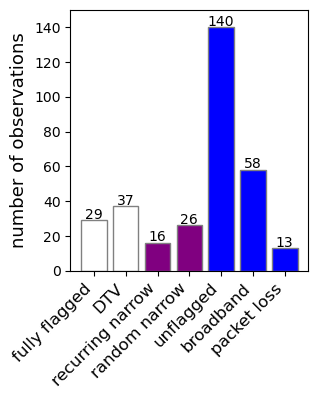

In [30]:
# make a plot of final rfi specs
plot_dict = {}
plot_dict["fully flagged"] = len(df_o2.loc[df_o2['fully_flagged'] == 1])
plot_dict["DTV"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 1)])
plot_dict["recurring narrow"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 0) & (df_std["any_recur_nb"]==1)])
plot_dict["random narrow"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 0) & (df_std["any_recur_nb"]==0) & (df_std["any_rando_nb"]==1)])
plot_dict["unflagged"] = len(final_set.loc[final_set['unflagged'] == 1])
plot_dict["broadband"] = len(final_set.loc[final_set['any_streak'] == 1])
plot_dict["packet loss"] = len(final_set.loc[final_set['any_pdrop'] == 1])
print(plot_dict["unflagged"])
print(len(final_set))
colors = ["white", "white", "purple", "purple", "blue", "blue", "blue"]
names = plot_dict.keys()
counts = list(plot_dict.values())
print(counts)
fig, ax = plt.subplots(figsize=(3.5,4.5))
ax.bar(names, counts, color=colors, edgecolor='grey')
for i in range(7):
    plt.text(i, counts[i]+1, counts[i], ha='center')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_ylim(0, 150)
ax.set_ylabel("number of observations", fontsize=13)
plt.subplots_adjust(left=0.22, bottom=0.3)
plt.show()
fig.savefig('/Users/pstar/EORanalysis/thesis_plots/final_rfi_cuts_bar.pdf')
plt.close()

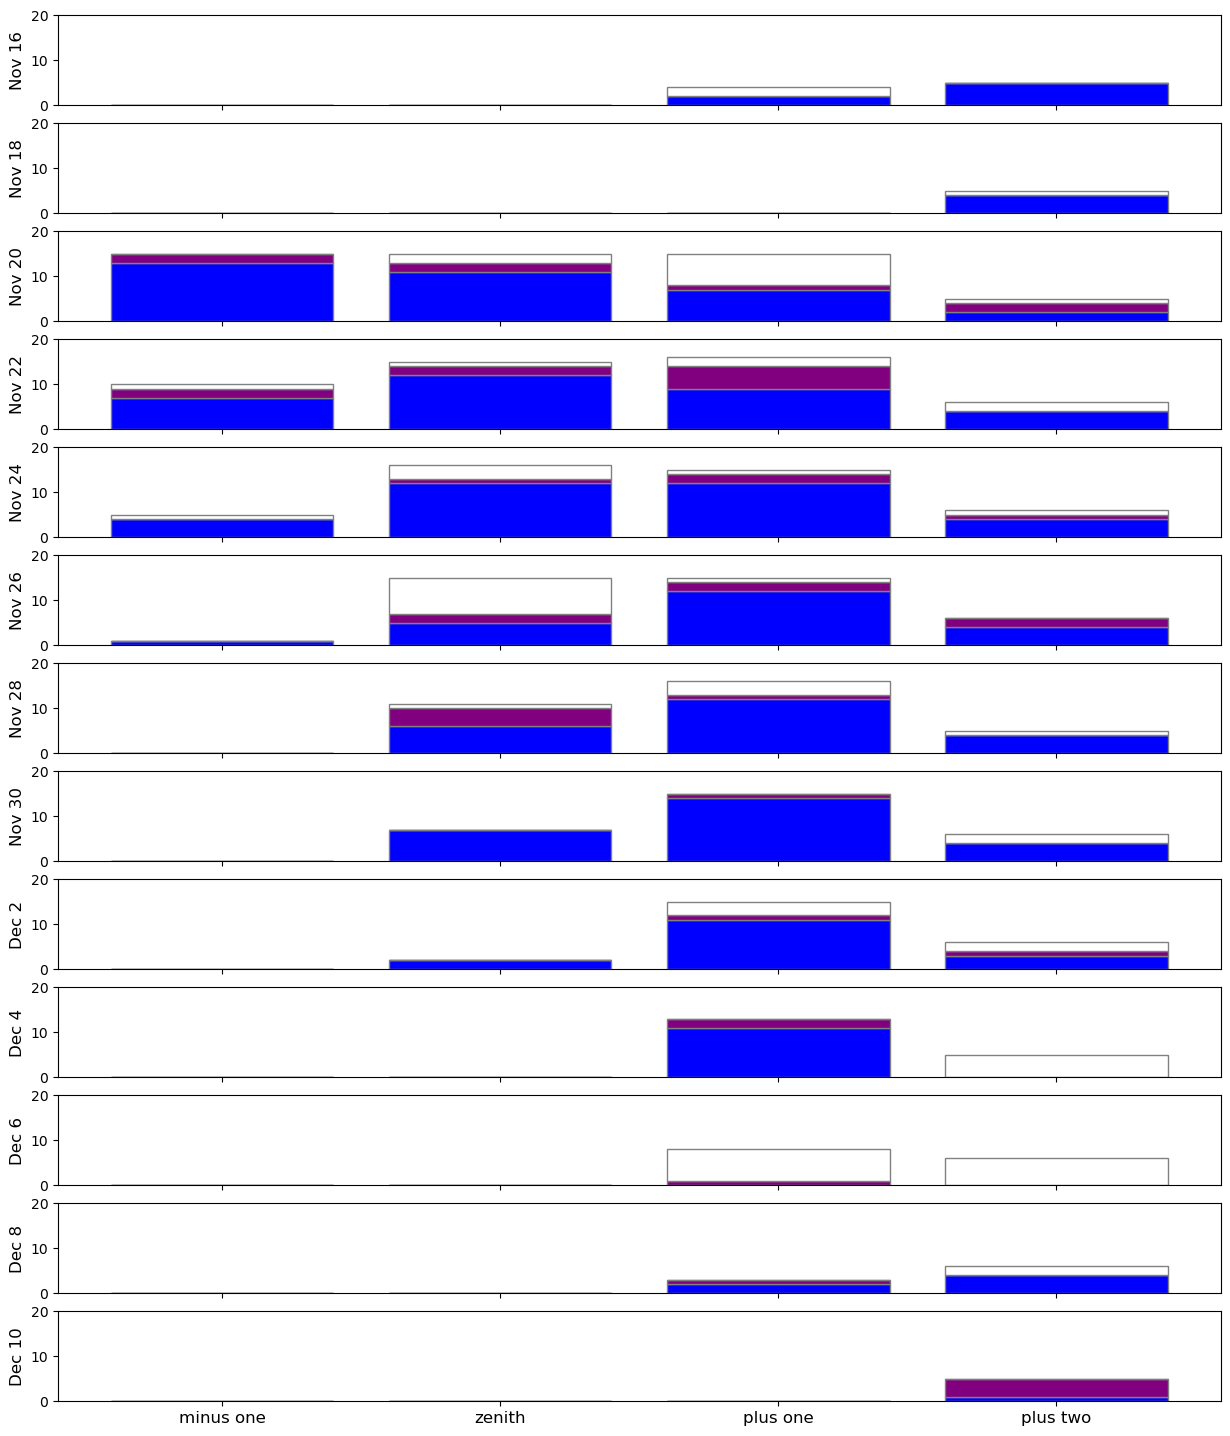

In [31]:
# this code generate a bar chart showing a distribution of rfi for each pointing-day
# In particular, there are three categories I'm using:
# 1. observations which are fully flagged and those not fully flagged with DTV
# 2. observations not in the previous category with narrowband RFI
# 3. observations not in the previous two categories
# Additionally, I'm using two data frames, one for a ssins run with order=2
# and one for a ssins run with mean (instead of polynomial) subtraction.
# Finally: this is not optimized or cute; it's a quick and dirty plot I made for my thesis.
# There's a lot of hardcoding here. Feel free to make it better/more useful. Enjoy!

dates = ["Nov 16", "Nov 18", "Nov 20", "Nov 22", "Nov 24", "Nov 26", "Nov 28", "Nov 30", "Dec 2", "Dec 4", "Dec 6", "Dec 8", "Dec 10"]
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
days = [-2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axes = plt.subplots(nrows=13, figsize=(15, 18))
for i in range(13):
    bottom = np.full(4, 0.0)
    ax = axes[i]
    trash = {}
    nb = {}
    keep = {}
    for j in pointings:
        trash[j] = len(df_o2.loc[(df_o2['day'] == days[i]) & (df_o2['pointing'] == j) & ((df_o2['fully_flagged'] == 1) | (df_o2["any_tv"] == 1))])
        nb[j] = len(df_o2.loc[(df_o2['day'] == days[i]) & (df_o2['pointing'] == j) & (df_o2['fully_flagged']==0) & (df_o2['any_tv'] == 0) & ((df_std['any_recur_nb']==1) | (df_std['any_rando_nb']==1))])
        keep[j] = len(final_set.loc[(final_set['day'] == days[i]) & (final_set['pointing'] == j)])
    ax.bar(pointing_labels, keep.values(), bottom=bottom, color='blue', edgecolor='grey')
    bottom += np.array(list(keep.values()))
    ax.bar(pointing_labels, nb.values(), bottom=bottom, color='purple', edgecolor='grey')
    bottom += np.array(list(nb.values()))
    ax.bar(pointing_labels, trash.values(), bottom=bottom, color='white', edgecolor='grey')
    ax.set_ylim(0,20)
    if i == 12:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=12)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_ylabel(dates[i], fontsize=12)
plt.show()
plt.close()

In [32]:
with open("/Users/pstar/EORanalysis/final_run_cut_lists/175_nb.txt", 'w') as f:
    for i in df2.loc[df2['narrow_175.000MHz']==1].index:
        f.write(f"{i}\n")

In [33]:
# make cut lists!!!
for i in final_set.index:
    day = str(int(final_set.loc[i, 'day']))
    pointing = str(int(final_set.loc[i, 'pointing']))
    with open("/Users/pstar/EORanalysis/final_run_cut_lists/mwax_final_" + day + "_" + pointing + ".txt", "a") as f:
        f.write(f"{i}\n")

In [34]:
# make cut lists!!!
for i in final_set.index:
    day = str(int(final_set.loc[i, 'day']))
    with open("/Users/pstar/EORanalysis/final_run_cut_lists/full_mwax_final_" + day + ".txt", "a") as f:
        f.write(f"{i}\n")

In [35]:
with open("/Users/pstar/EORanalysis/final_run_cut_lists/recur_nb.txt", 'w') as f:
    for i in df_std.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_recur_nb==1)].index:
        f.write(f"{i}\n")
with open("/Users/pstar/EORanalysis/final_run_cut_lists/rando_nb.txt", 'w') as f:
    for i in df_std.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_rando_nb==1) & (df_std.any_recur_nb==0)].index:
        f.write(f"{i}\n")

In [36]:
df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0)]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1321789208,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,355.528582,3.0,2.0
1321963536,0,44,1,0,0,1,0,0,0,0,...,0,0,0,0,0,[0],0,3.883958,4.0,0.0
1322653416,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,6.253902,8.0,4.0
1321448704,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,12.877446,1.0,12.0
1321619432,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,6.191777,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322308720,0,55,1,0,0,1,0,0,0,0,...,0,0,0,0,0,[0],0,6.088329,6.0,4.0
1321966056,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,14.412705,4.0,12.0
1321444024,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,353.324057,1.0,2.0
1322482088,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,10.432716,7.0,4.0


In [37]:
df_std.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_recur_nb==1)]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1322826424,0,49,1,0,0,1,1,0,0,0,...,0,0,0,1,4,[0],0,9.094298,9.0,4.0
1321790768,0,56,1,0,0,0,1,0,0,0,...,0,0,0,0,3,[0],0,2.046379,3.0,0.0
1321447024,0,30,1,0,0,1,1,0,0,0,...,1,0,0,0,14,[0],0,5.858280,1.0,4.0
1321448824,0,55,1,0,0,0,1,0,0,0,...,0,0,0,1,3,[0],0,13.378815,1.0,12.0
1321620392,0,47,1,0,1,1,1,0,0,0,...,0,0,0,1,4,[0],0,10.202728,2.0,4.0
1321963056,0,51,1,0,0,0,1,0,0,0,...,0,0,0,1,7,[0],0,1.878482,4.0,0.0
1321620632,0,40,1,0,0,1,1,0,0,0,...,0,0,0,1,4,[0],0,11.205466,2.0,4.0
1322482448,0,55,1,0,0,0,1,1,0,0,...,0,0,0,0,2,[186.96],1,11.936823,7.0,12.0
1321620272,0,46,1,0,0,1,1,0,0,0,...,0,0,0,1,4,[0],0,9.701359,2.0,4.0
1323171952,0,33,1,0,0,1,1,0,0,0,...,0,0,0,0,2,[0],0,12.736060,11.0,12.0


In [38]:
df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_rando_nb==1) & (df_std.any_recur_nb==0)]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1322308960,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,7.091067,6.0,4.0
1321445824,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,0.844591,1.0,0.0
1322481848,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,9.429978,7.0,4.0
1321964136,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,6.390802,4.0,4.0
1322135592,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[180.16],1,2.746708,5.0,0.0
1321962816,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,0.875744,4.0,0.0
1322653776,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,7.758009,8.0,4.0
1322999192,0,57,1,0,0,0,0,1,0,0,...,0,0,0,0,0,"[167.48, 167.48]",2,10.931924,10.0,4.0
1322134752,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,359.237125,5.0,0.0
1323172192,1,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,[0],0,13.738798,11.0,12.0


In [39]:
np.setdiff1d(df_std.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_recur_nb==1)].index, df_o2.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_o2.any_recur_nb==1)].index)

array([1322482448])

In [40]:
df_std.loc[1321618952]

unflagged                                  0
n_times_unflagged                         54
flags                                      1
fully_flagged                              0
any_tv                                     1
any_streak                                 0
any_recur_nb                               1
any_rando_nb                               0
any_pdrop                                  0
pdrop_ntimes                               0
TV6                                        0
time_broadcast_TV6                         0
TV7                                        1
time_broadcast_TV7                         0
TV8                                        0
time_broadcast_TV8                         0
TV9                                        0
time_broadcast_TV9                         0
TV_ntimes                                  2
streak                                     0
time_broadcast_streak                      0
streak_ntimes                              0
narrow_168

In [41]:
df_std.loc[df_std['narrow_172.800MHz']==1]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1321790768,0,56,1,0,0,0,1,0,0,0,...,0,0,0,0,3,[0],0,2.046379,3.0,0.0
1321618952,0,54,1,0,1,0,1,0,0,0,...,0,0,0,0,2,[0],0,4.186301,2.0,4.0
1321963056,0,51,1,0,0,0,1,0,0,0,...,0,0,0,1,7,[0],0,1.878482,4.0,0.0
1322482448,0,55,1,0,0,0,1,1,0,0,...,0,0,0,0,2,[186.96],1,11.936823,7.0,12.0
1321962216,0,0,1,1,0,0,1,0,0,0,...,1,1,0,0,88,[0],0,358.368899,4.0,0.0
1321618832,0,43,1,0,0,1,1,0,0,0,...,0,0,0,0,2,[0],0,3.684932,2.0,0.0


In [42]:
df_std.loc[(df_o2.fully_flagged==0) & (df_o2.any_tv==0) & (df_std.any_rando_nb==1) & (df_std.any_recur_nb==0)]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1322308960,0,50,1,0,1,1,0,1,0,0,...,0,0,0,0,0,[197.6],1,7.091067,6.0,4.0
1321445824,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[173.04],1,0.844591,1.0,0.0
1322481848,0,41,1,0,0,1,0,1,0,0,...,0,0,0,0,0,[190.48],1,9.429978,7.0,4.0
1321964136,0,47,1,0,0,1,0,1,0,0,...,0,0,0,0,0,[195.44],1,6.390802,4.0,4.0
1322135592,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[180.16],1,2.746708,5.0,0.0
1321962816,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[196.6],1,0.875744,4.0,0.0
1322653776,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[187.32],1,7.758009,8.0,4.0
1322999192,0,52,1,0,0,1,0,1,0,0,...,0,0,0,0,0,"[167.48, 167.48, 167.48]",3,10.931924,10.0,4.0
1322134752,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[173.2],1,359.237125,5.0,0.0
1323172192,0,57,1,0,0,1,0,1,0,0,...,0,0,0,0,0,[185.08],1,13.738798,11.0,12.0


In [43]:
df_o2.loc[1321963776]

unflagged                                  0
n_times_unflagged                         33
flags                                      1
fully_flagged                              0
any_tv                                     0
any_streak                                 1
any_recur_nb                               0
any_rando_nb                               1
any_pdrop                                  0
pdrop_ntimes                               0
TV6                                        0
time_broadcast_TV6                         0
TV7                                        0
time_broadcast_TV7                         0
TV8                                        0
time_broadcast_TV8                         0
TV9                                        0
time_broadcast_TV9                         0
TV_ntimes                                  0
streak                                     1
time_broadcast_streak                      0
streak_ntimes                             23
narrow_168

In [44]:
for i in df.loc[df['any_recur_nb']==1].index:
    if i not in df2.loc[df2['any_recur_nb']==1].index:
        print(i)

1322654856
1321961976
1322308240


In [45]:
for i in df2.loc[df2['any_recur_nb']==1].index:
    if i not in df_nb.loc[df_nb['any_recur_nb']==1].index:
        print(i)

1321618592
1321962096
1321962216
1321962456
1322827144
1322826784


In [46]:
df_nb.loc[1321962096]

unflagged                                                                           0
n_times_unflagged                                                                   0
flags                                                                               1
fully_flagged                                                                       1
any_tv                                                                              0
any_streak                                                                          0
any_recur_nb                                                                        0
any_rando_nb                                                                        1
any_pdrop                                                                           0
pdrop_ntimes                                                                        0
TV6                                                                                 0
time_broadcast_TV6                                    

In [47]:
chans = np.array(df_nb.loc[1321962096, ['random_narrow_chan']])
print(chans)

[list([180.08, 180.12, 180.08, 180.12, 180.12, 180.12, 180.08, 180.08, 180.08, 180.36, 180.08, 180.08, 180.12, 180.36, 180.12, 180.08, 180.12, 180.12, 180.12, 180.08, 180.12, 180.12, 180.08, 180.12, 180.12, 180.12, 180.12, 180.12, 180.12, 180.12])]


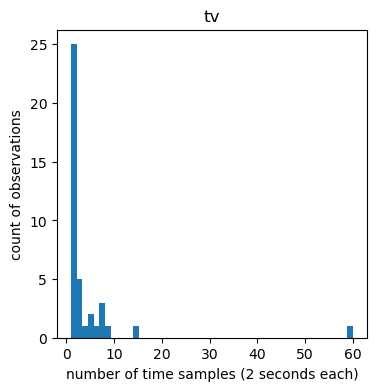

In [48]:
fig, ax = plt.subplots(figsize=(4,4))
plot_data = df.loc[df['any_tv'] == 1, ['TV_ntimes']]
ax.hist(plot_data, bins=50)
ax.set_ylabel('count of observations')
ax.set_xlabel('number of time samples (2 seconds each)')
ax.set_title('tv')
plt.show()
plt.close()

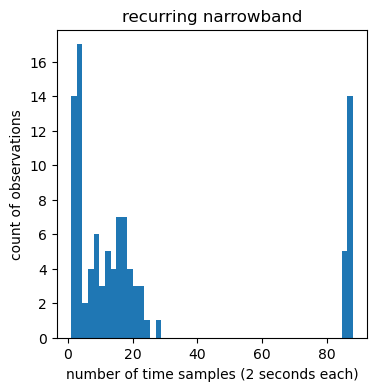

In [49]:
fig, ax = plt.subplots(figsize=(4,4))
plot_data = df.loc[df['any_recur_nb'] == 1, ['narrow_ntimes']]
ax.hist(plot_data, bins=50)
ax.set_ylabel('count of observations')
ax.set_xlabel('number of time samples (2 seconds each)')
ax.set_title('recurring narrowband')
plt.show()
plt.close()

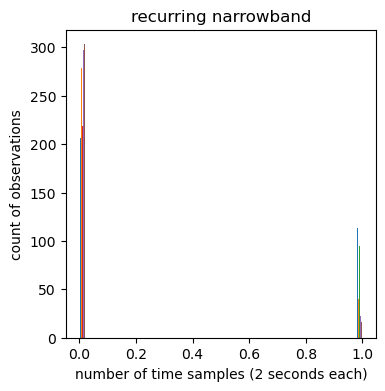

In [50]:
fig, ax = plt.subplots(figsize=(4,4))
plot_data = df.loc[:, ["unflagged", "any_tv", "any_streak", "any_recur_nb", 'any_rando_nb', 'any_pdrop']]
ax.hist(plot_data, bins=50)
ax.set_ylabel('count of observations')
ax.set_xlabel('number of time samples (2 seconds each)')
ax.set_title('recurring narrowband')
plt.show()
plt.close()

In [51]:
tv_count = len(df.loc[df['any_tv'] == 1])
recur_nb_count = len(df.loc[(df['any_recur_nb'] == 1) & (df['any_tv'] == 0)])
rando_nb_count = len(df.loc[(df['any_rando_nb'] == 1)& (df['any_tv'] == 0)])
streak_count = len(df.loc[df['any_streak'] == 1])
pdrop_count = len(df.loc[df['any_pdrop'] == 1])
unflagged_count = len(df.loc[df['unflagged'] == 1])

In [52]:
final_set.loc[final_set['any_rando_nb'] == 1]

,unflagged,n_times_unflagged,flags,fully_flagged,any_tv,any_streak,any_recur_nb,any_rando_nb,any_pdrop,pdrop_ntimes,...,narrow_180.000MHz,time_broadcast_narrow_180.000MHz,narrow_191.440MHz,narrow_191.480MHz,narrow_ntimes,random_narrow_chan,random_narrow_ntimes,lst,day,pointing
1321793648,0,58,1,0,0,0,0,1,0,0,...,0,0,0,0,0,[168.16],1,14.079234,3.0,12.0
1321963776,0,33,1,0,0,1,0,1,0,0,...,0,0,0,0,0,[175.2],1,4.886695,4.0,4.0


140
211
[29, 37, 16, 26, 140, 58, 13]


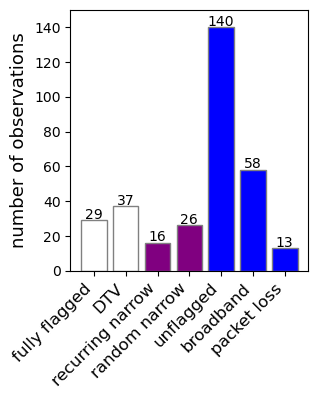

In [53]:
# make a plot of final rfi specs
plot_dict = {}
plot_dict["fully flagged"] = len(df_o2.loc[df_o2['fully_flagged'] == 1])
plot_dict["DTV"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 1)])
plot_dict["recurring narrow"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 0) & (df_std["any_recur_nb"]==1)])
plot_dict["random narrow"] = len(df_o2.loc[(df_o2['fully_flagged'] == 0) & (df_o2["any_tv"] == 0) & (df_std["any_recur_nb"]==0) & (df_std["any_rando_nb"]==1)])
plot_dict["unflagged"] = len(final_set.loc[final_set['unflagged'] == 1])
plot_dict["broadband"] = len(final_set.loc[final_set['any_streak'] == 1])
plot_dict["packet loss"] = len(final_set.loc[final_set['any_pdrop'] == 1])
print(plot_dict["unflagged"])
print(len(final_set))
colors = ["white", "white", "purple", "purple", "blue", "blue", "blue"]
names = plot_dict.keys()
counts = list(plot_dict.values())
print(counts)
fig, ax = plt.subplots(figsize=(3.5,4.5))
ax.bar(names, counts, color=colors, edgecolor='grey')
for i in range(7):
    plt.text(i, counts[i]+1, counts[i], ha='center')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_ylim(0, 150)
ax.set_ylabel("number of observations", fontsize=13)
plt.subplots_adjust(left=0.22, bottom=0.3)
plt.show()
fig.savefig('/Users/pstar/EORanalysis/thesis_plots/final_rfi_cuts_bar.pdf')
plt.close()

In [54]:
len(df_o2.loc[(df_o2['fully_flagged'] == 1) | (df_o2["any_tv"] == 1)])

66

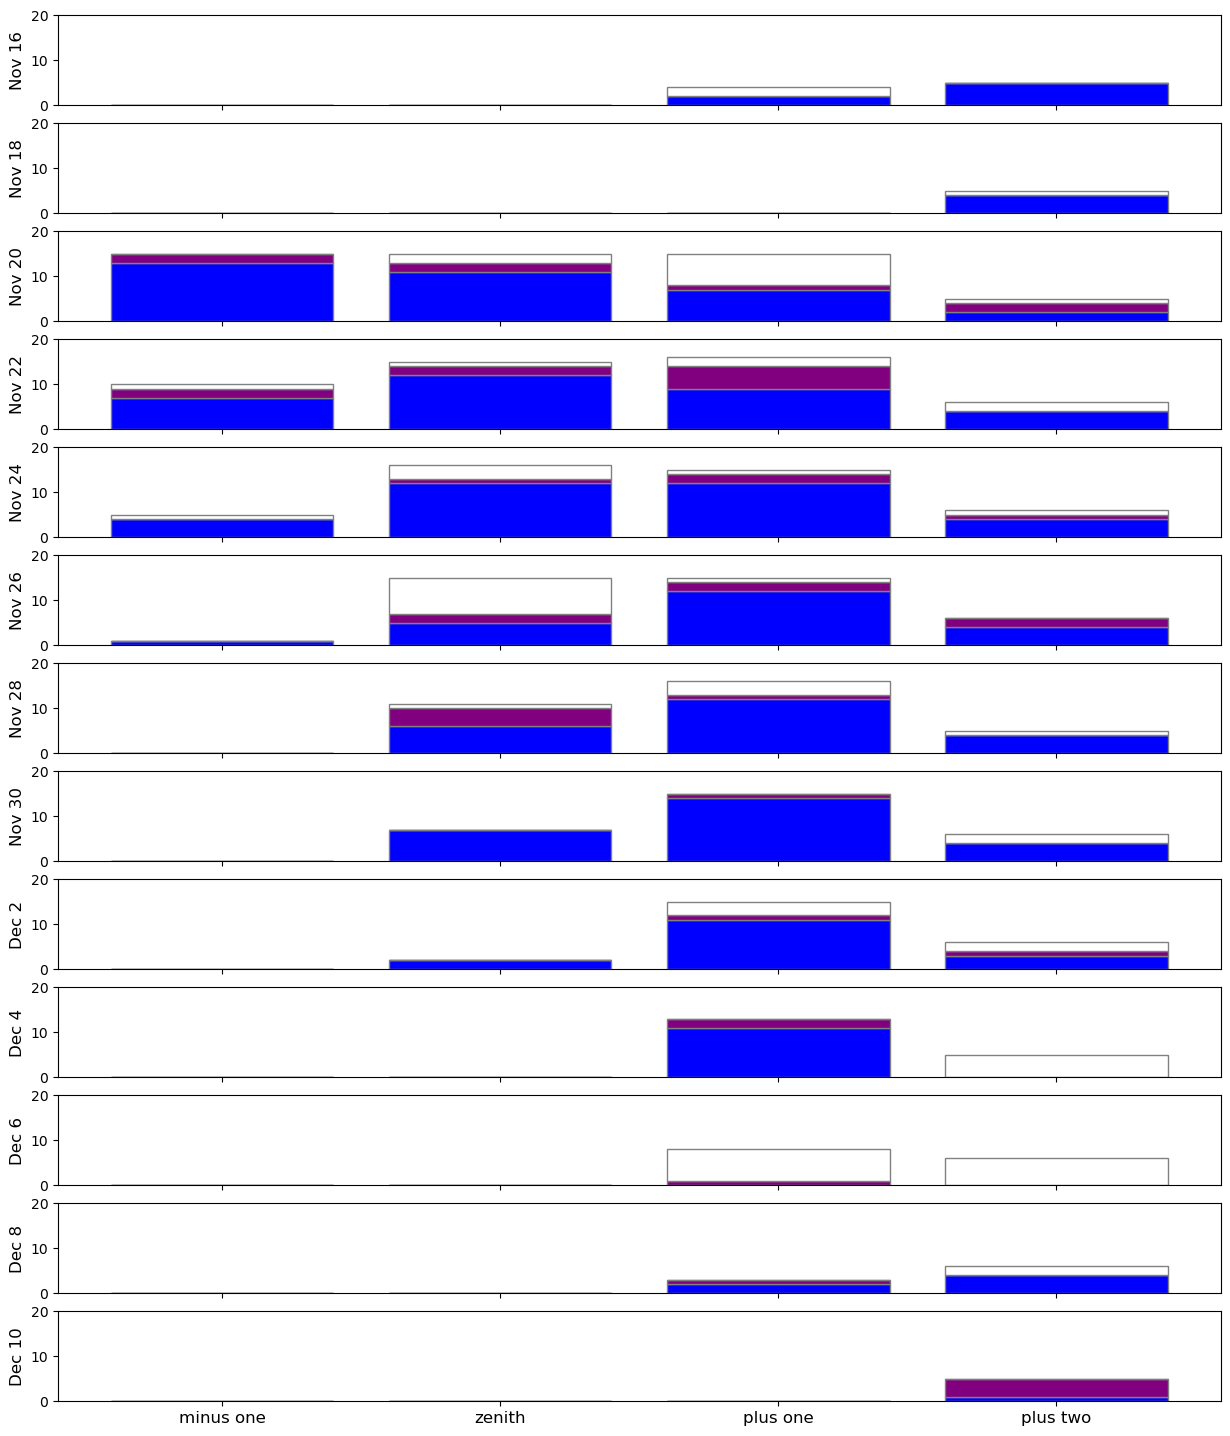

In [55]:
# make a plot showing pointing distribution for each night
dates = ["Nov 16", "Nov 18", "Nov 20", "Nov 22", "Nov 24", "Nov 26", "Nov 28", "Nov 30", "Dec 2", "Dec 4", "Dec 6", "Dec 8", "Dec 10"]
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
fig, axes = plt.subplots(nrows=13, figsize=(15, 18))
days = [-2, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for i in range(13):
    bottom = np.full(4, 0.0)
    ax = axes[i]
    trash = {}
    nb = {}
    keep = {}
    for j in pointings:
        trash[j] = len(df_o2.loc[(df_o2['day'] == days[i]) & (df_o2['pointing'] == j) & ((df_o2['fully_flagged'] == 1) | (df_o2["any_tv"] == 1))])
        nb[j] = len(df_o2.loc[(df_o2['day'] == days[i]) & (df_o2['pointing'] == j) & (df_o2['fully_flagged']==0) & (df_o2['any_tv'] == 0) & ((df_std['any_recur_nb']==1) | (df_std['any_rando_nb']==1))])
        keep[j] = len(final_set.loc[(final_set['day'] == days[i]) & (final_set['pointing'] == j)])
    ax.bar(pointing_labels, keep.values(), bottom=bottom, color='blue', edgecolor='grey')
    bottom += np.array(list(keep.values()))
    ax.bar(pointing_labels, nb.values(), bottom=bottom, color='purple', edgecolor='grey')
    bottom += np.array(list(nb.values()))
    ax.bar(pointing_labels, trash.values(), bottom=bottom, color='white', edgecolor='grey')
    ax.set_ylim(0,20)
    if i == 12:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), fontsize=12)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_ylabel(dates[i], fontsize=12)
plt.show()
plt.close()

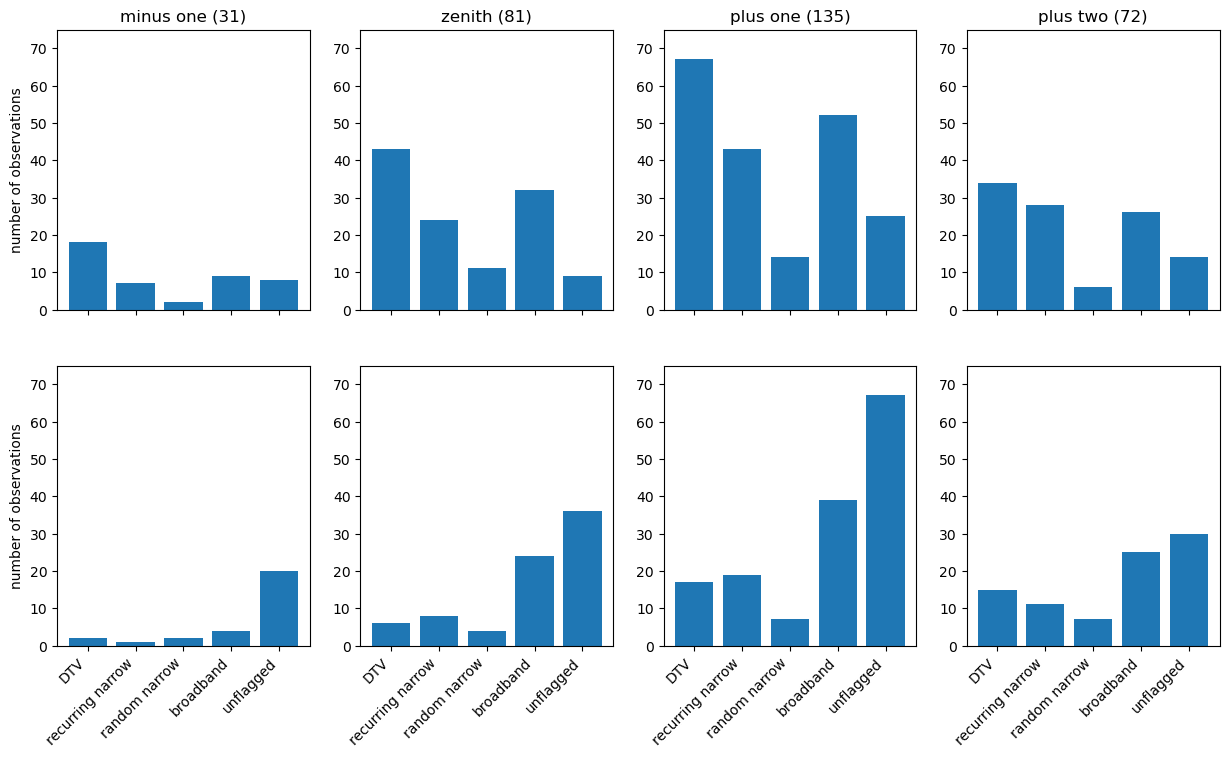

In [67]:
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
for j, d in enumerate([df2, df]):
    for i in range(4):
        ax = axes[j,i]
        plot_data = d.loc[d['pointing'] == pointings[i], ["any_tv", "any_recur_nb", 'any_rando_nb', "any_streak", "unflagged"]]
        scale = plot_data.shape[0]
        plot_data = plot_data.sum().to_dict()
        names = ["DTV", "recurring narrow", "random narrow", "broadband", "unflagged"]
        counts = plot_data.values()
        scaled_counts = [j/scale for j in counts]
        ax.bar(names, counts)
        if i== 0:
            ax.set_ylabel("number of observations")
        if j == 0:
            ax.set_title(pointing_labels[i] + ' (' + str(scale) + ')')
            ax.xaxis.set_tick_params(labelbottom=False)
        else:
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_ylim(0, 75)
plt.show()
plt.close()

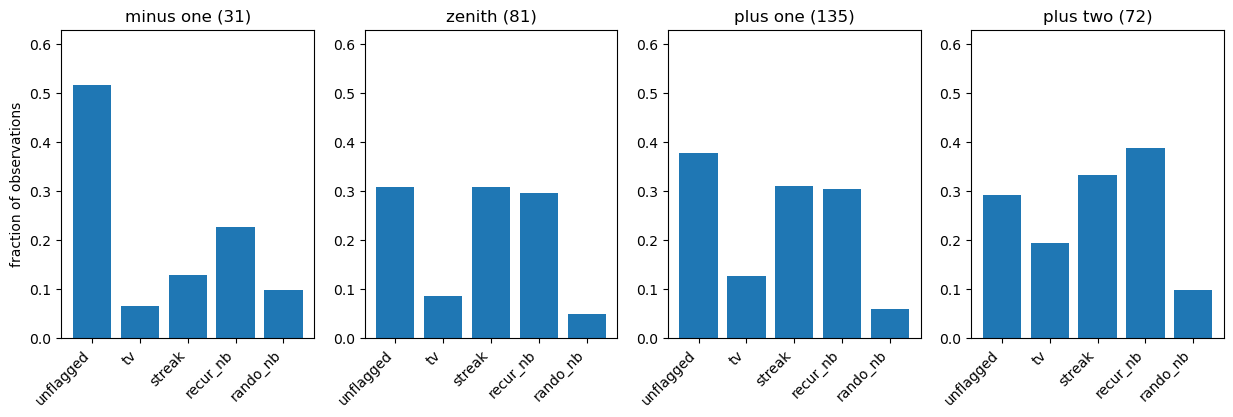

In [57]:
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
fig, axes = plt.subplots(ncols=4, figsize=(15,4))
for i in range(4):
    ax = axes[i]
    plot_data = df.loc[df['pointing'] == pointings[i], ["unflagged", "any_tv", "any_streak", "any_recur_nb", 'any_rando_nb']]
    scale = plot_data.shape[0]
    plot_data = plot_data.sum().to_dict()
    names = plot_data.keys()
    new_names = ["unflagged"]
    new_names = [j[4:] for j in names]
    new_names = ["unflagged"] + new_names[1:]
    counts = plot_data.values()
    scaled_counts = [j/scale for j in counts]
    ax.bar(new_names, scaled_counts)
    if i== 0:
        ax.set_ylabel("fraction of observations")
    ax.set_title(pointing_labels[i] + ' (' + str(scale) + ')')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 0.63)
plt.show()
plt.close()

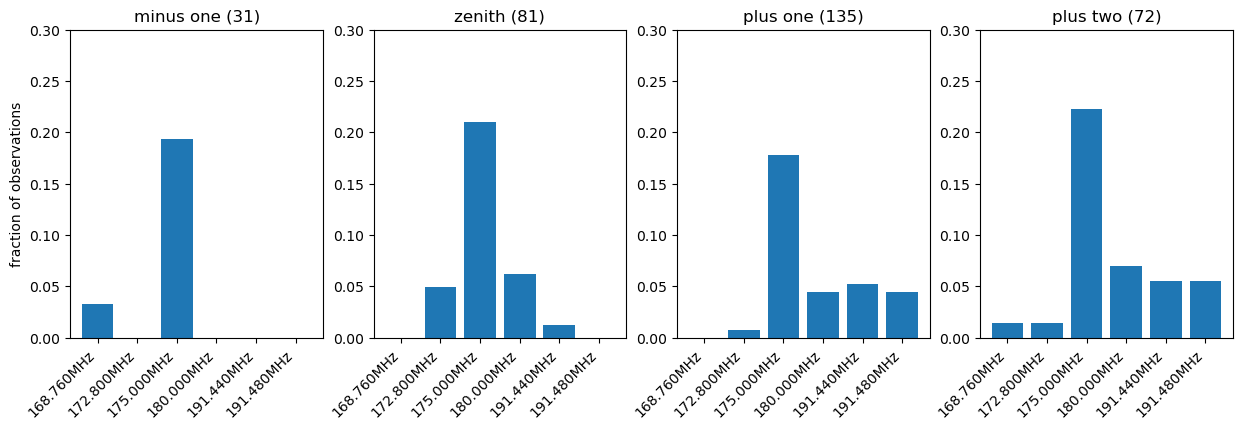

In [58]:
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
fig, axes = plt.subplots(ncols=4, figsize=(15,4))
for i in range(4):
    ax = axes[i]
    plot_data = df.loc[df['pointing'] == pointings[i], ['narrow_168.760MHz','narrow_172.800MHz','narrow_175.000MHz','narrow_180.000MHz','narrow_191.440MHz','narrow_191.480MHz']]
    scale = plot_data.shape[0]
    plot_data = plot_data.sum().to_dict()
    names = plot_data.keys()
    new_names = [j.split('_')[1] for j in names]
    counts = plot_data.values()
    scaled_counts = [j/scale for j in counts]
    ax.bar(new_names, scaled_counts)
    if i== 0:
        ax.set_ylabel("fraction of observations")
    ax.set_title(pointing_labels[i] + ' (' + str(scale) + ')')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 0.3)
plt.show()
plt.close()

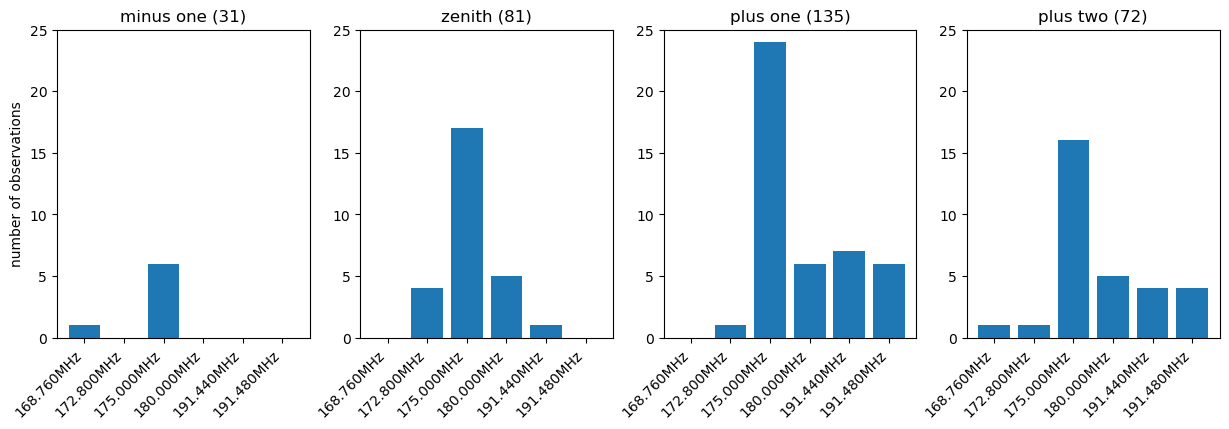

In [59]:
pointings = [2, 0, 4, 12]
pointing_labels = ['minus one', 'zenith', 'plus one', 'plus two']
fig, axes = plt.subplots(ncols=4, figsize=(15,4))
for i in range(4):
    ax = axes[i]
    plot_data = df.loc[df['pointing'] == pointings[i], ['narrow_168.760MHz','narrow_172.800MHz','narrow_175.000MHz','narrow_180.000MHz','narrow_191.440MHz','narrow_191.480MHz']]
    scale = plot_data.shape[0]
    plot_data = plot_data.sum().to_dict()
    names = plot_data.keys()
    new_names = [j.split('_')[1] for j in names]
    counts = plot_data.values()
    scaled_counts = [j/scale for j in counts]
    ax.bar(new_names, counts)
    if i== 0:
        ax.set_ylabel("number of observations")
    ax.set_title(pointing_labels[i] + ' (' + str(scale) + ')')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0, 25)
plt.show()
plt.close()